🔧 What This Notebook Will Do
It will:

📥 Load transcription comparison results from turkish_transcribe_and_compare.ipynb

✅ Clean and normalize the text

✂️ Tokenize and count word frequencies (separately for:

Whisper predictions

Wav2Vec2 predictions

Ground truth labels)

🧹 Optionally remove Turkish stopwords

📊 Save frequency tables (CSV/JSON)

📈 Plot top-N word frequency histograms

In [19]:
# ✅ Cell 1: Imports & Path Setup
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import networkx as nx
from pathlib import Path

# Setup root and output paths
PROJECT_ROOT = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path.cwd().parents[1]
TRANSCRIPTION_PATH = PROJECT_ROOT / "outputs" / "transcriptions" / "turkish_transcription_comparison.csv"
FREQ_DIR = PROJECT_ROOT / "outputs" / "frequencies" / "turkish"
GRAPH_DIR = PROJECT_ROOT / "outputs" / "visualizations"

FREQ_DIR.mkdir(parents=True, exist_ok=True)
GRAPH_DIR.mkdir(parents=True, exist_ok=True)


In [20]:
# ✅ Cell 2: Load Transcription File
df = pd.read_csv(TRANSCRIPTION_PATH)
print(f"✅ Loaded {len(df)} Turkish transcription samples.")


✅ Loaded 11352 Turkish transcription samples.


In [21]:
# ✅ Cell 3: Normalization + Tokenizer with Stopwords
turkish_stopwords = {
    "ve", "bir", "bu", "da", "de", "için", "ne", "ile", "gibi", "ama", "ya", "çok", "ki", "mi",
    "ben", "sen", "o", "biz", "siz", "onlar", "şu", "şey", "var", "yok", "diye", "mı", "mu", "mü"
}

def normalize_text(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r"[^\w\sçğıöşü]", "", text)
    return re.sub(r"\s+", " ", text).strip()

def tokenize(text, remove_stopwords=True):
    tokens = normalize_text(text).split()
    tokens = [t for t in tokens if t.isalpha() and len(t) > 1]
    if remove_stopwords:
        tokens = [t for t in tokens if t not in turkish_stopwords]
    return tokens


In [22]:
# ✅ Cell 4: Word Frequency Counters
def get_word_counts(texts, remove_stopwords=True):
    counter = Counter()
    for t in texts:
        counter.update(tokenize(t, remove_stopwords))
    return counter

gt_counts = get_word_counts(df["ground_truth"])
whisper_counts = get_word_counts(df["whisper_pred"])
w2v2_counts = get_word_counts(df["w2v2_pred"])

gt_counts_raw = get_word_counts(df["ground_truth"], remove_stopwords=False)


In [23]:
# ✅ Cell 5: Top-Word Overlap Before/After Stopword Filtering
top_with_stopwords = [w for w, _ in gt_counts_raw.most_common(30)]
top_without_stopwords = [w for w, _ in gt_counts.most_common(30)]
overlap = len(set(top_with_stopwords) & set(top_without_stopwords)) / len(top_with_stopwords)

print("🆚 Top words before stopword removal:", top_with_stopwords)
print("✅ Top words after stopword removal:", top_without_stopwords)
print(f"🔁 Overlap (with vs without stopwords): {overlap:.2f}")


🆚 Top words before stopword removal: ['bir', 'bu', 've', 'ne', 'de', 'tr', 'da', 'çok', 'ben', 'için', 'daha', 'sonra', 'kadar', 'mi', 'var', 'değil', 'gibi', 'twenties', 'şey', 'iki', 'mı', 'fakat', 'onu', 'bunu', 'her', 'bana', 'sen', 'beni', 'iyi', 'hiç']
✅ Top words after stopword removal: ['tr', 'daha', 'sonra', 'kadar', 'değil', 'twenties', 'iki', 'fakat', 'onu', 'bunu', 'her', 'bana', 'beni', 'iyi', 'hiç', 'olarak', 'zaman', 'biraz', 'evet', 'oldu', 'en', 'on', 'benim', 'seni', 'hayır', 'nasıl', 'doğru', 'burada', 'beş', 'büyük']
🔁 Overlap (with vs without stopwords): 0.50


In [24]:
# ✅ Cell 6: Convert to Frequency Tables
def to_freq_df(counter, name):
    df_freq = pd.DataFrame(counter.items(), columns=["word", f"{name}_freq"])
    return df_freq.sort_values(by=f"{name}_freq", ascending=False)

df_gt = to_freq_df(gt_counts, "gt")
df_whisper = to_freq_df(whisper_counts, "whisper")
df_w2v2 = to_freq_df(w2v2_counts, "w2v2")


In [25]:
# ✅ Cell 7: Save Frequency Tables (Cleaned)
df_gt.to_csv(FREQ_DIR / "gt_word_freq.csv", index=False)
df_whisper.to_csv(FREQ_DIR / "whisper_word_freq.csv", index=False)
df_w2v2.to_csv(FREQ_DIR / "w2v2_word_freq.csv", index=False)

print("✅ Saved cleaned word frequency tables.")


✅ Saved cleaned word frequency tables.


In [26]:
# ✅ Cell 8: Co-occurrence Graph (from GT)
G = nx.Graph()
for sentence in df["ground_truth"]:
    words = tokenize(sentence)
    for i in range(len(words)):
        for j in range(i + 1, min(i + 3, len(words))):
            if words[i] != words[j]:
                G.add_edge(words[i], words[j], weight=G.get_edge_data(words[i], words[j], {"weight": 0})["weight"] + 1)

nx.write_gexf(G, GRAPH_DIR / "turkish_gt_word_cooccurrence.gexf")
print("✅ Co-occurrence graph saved.")


✅ Co-occurrence graph saved.


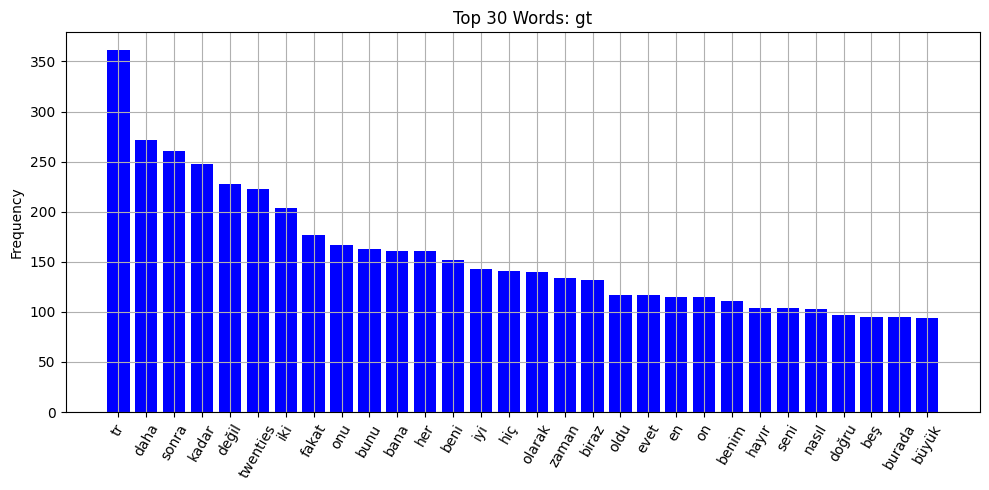

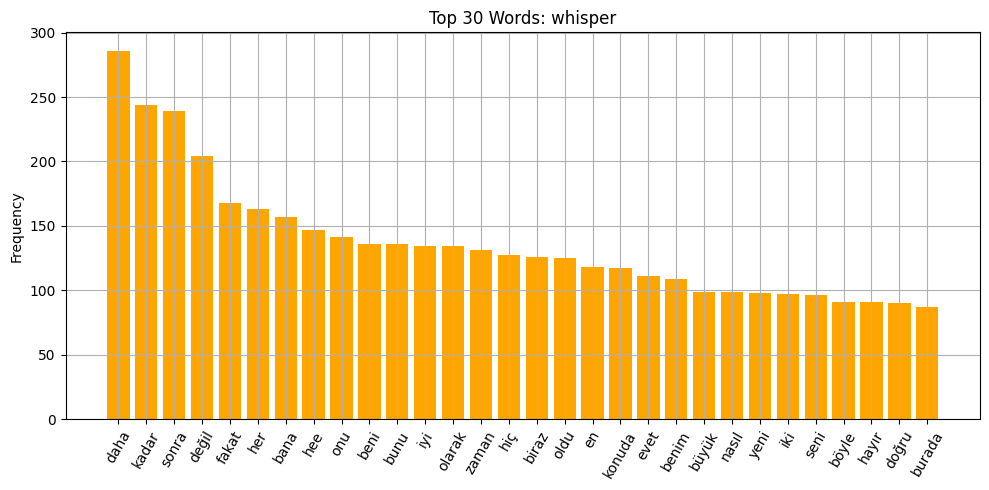

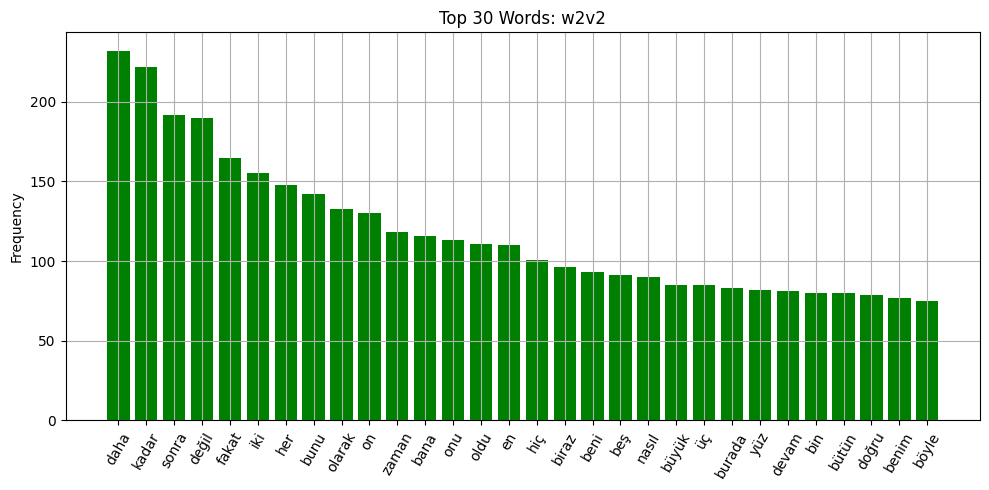

In [27]:
# ✅ Cell 9: Plot Top-30 Word Frequencies
def plot_top_words(freq_df, label, color="steelblue"):
    top = freq_df.head(30)
    plt.figure(figsize=(10, 5))
    plt.bar(top["word"], top[f"{label}_freq"], color=color)
    plt.xticks(rotation=60)
    plt.title(f"Top 30 Words: {label}")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.grid(True)
    plt.show()

plot_top_words(df_gt, "gt", "blue")
plot_top_words(df_whisper, "whisper", "orange")
plot_top_words(df_w2v2, "w2v2", "green")
